In [ ]:
!pip install DeepForest
!pip install pyforest
!pip install umap-learn
!pip install scikit-optimize
!pip install xgboost
!pip install lightgbm
!pip install deepchem
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of rasterio to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.6/585.6 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 48.5 MB/s 

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.2-py2.py3-none-any.whl size=15902 sha256=7d00b01bdbba66c127b442f2a0fadb0497f682b1a7cff8e3398b9eaf4c19cadf
  Stored in directory: /root/.cache/pip/wheels/66/4f/3c/cbdf5336b5a84f39cb6e3d76eecb9acf3f99a2c072785afecc
Successfully built pyforest
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.1
    Uninstalling scikit-learn-1.5.1:
      Successfully uninstalled scikit-learn-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.4 MB/s eta 0:

In [ ]:
import pandas as pd
import deepchem as dc
from rdkit import Chem
import random, umap, time, joblib
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from skopt import BayesSearchCV
from skopt.plots import plot_objective
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from deepforest import CascadeForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, roc_auc_score, matthews_corrcoef, classification_report # evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve # plots
import shap # feature importance


Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 23.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hdbscan 0.8.41 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


ModuleNotFoundError: No module named 'deepchem'

In [ ]:
import pandas as pd
data = 'https://raw.githubusercontent.com/Jjpn1/EZ-Breath-Model-Beta/main/cleaned_acp_lung_cancer.csv'
df = pd.read_csv(data)
y = df.iloc[:, 4].values
df.head()

,ID,Sequence,Result,Length,Smiles
0,1,AIGKFLHSAKKFGKAFVGEIMNS,1,23,N[C@@]([H])(C)C(=O)N[C@@]([H])([C@]([H])(CC)C)...
1,2,FAKALAKLAKKLL,1,13,N[C@@]([H])(Cc1ccccc1)C(=O)N[C@@]([H])(C)C(=O)...
2,3,FAKALKALLKALKAL,1,15,N[C@@]([H])(Cc1ccccc1)C(=O)N[C@@]([H])(C)C(=O)...
3,4,FAKFLAKFLKKAL,1,13,N[C@@]([H])(Cc1ccccc1)C(=O)N[C@@]([H])(C)C(=O)...
4,5,FAKIIAKIAKIAKKIL,0,16,N[C@@]([H])(Cc1ccccc1)C(=O)N[C@@]([H])(C)C(=O)...


In [ ]:
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # calculate the fraction of C-C pairs
    num_bonds = mol.GetNumBonds()
    num_cc_pairs = sum(1 for bond in mol.GetBonds() if bond.GetBeginAtom().GetSymbol() == 'C' and bond.GetEndAtom().GetSymbol() == 'C')
    frac_CC = num_cc_pairs / num_bonds if num_bonds > 0 else 0

    return frac_CC

In [ ]:
from rdkit import Chem
# Apply the function to each SMILES string in the DataFrame
df['frac_CC'] = df['smiles'].apply(calculate_properties)

# Scale fra_CC pairs column
scaler_qc = RobustScaler()
df[['frac_CC']] = scaler_qc.fit_transform(df[['frac_CC']])

<IPython.core.display.Javascript object>

In [ ]:
import deepchem as dc
# Featurize smiles
tasks = ['Result'] # Changed 'Ecoli' to 'Result'
featurizer = dc.feat.CircularFingerprint(radius=7, size=512, chiral=True, bonds=True,
                                        features=True)

loader = dc.data.CSVLoader(tasks=tasks, feature_field='smiles', featurizer=featurizer)
dataset = loader.create_dataset(data)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use

In [ ]:
# Scale ECFPs columns
scaler_ecfp = RobustScaler()
ecfp_scale = scaler_ecfp.fit_transform(dataset.X)

# Convert dataset.X to DataFrame
ecfp = pd.DataFrame(ecfp_scale)
col = ['ECFP' + str(x) for x in range(0,512)]
ecfp.columns = col


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Concatenate Q & frac_CC columns with the ECFPs
X = pd.concat([df[['frac_CC']], ecfp], axis=1)
X.head()



<IPython.core.display.Javascript object>

,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
0,-0.019539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0
1,-0.685719,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,-2.0,2.0,0.0
2,-1.896110,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,-1.0,-1.0,-2.0,0.0,2.0,0.0
3,-0.558043,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,...,1.0,-1.0,0.0,0.0,-1.0,0.0,-2.0,-2.0,0.0,1.0
4,0.525837,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,1.0,-1.0,0.0,0.0,-1.0,0.0,-2.0,0.0,0.0,0.0


In [ ]:
# Normalize the data
normalizer = MinMaxScaler()
X_norm = normalizer.fit_transform(X)

# Convert X_norm into DataFrame
X_norm = pd.DataFrame(X_norm, columns=X.columns)
print(X_norm.shape)
X_norm.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(15, 513)


,frac_CC,ECFP0,ECFP1,ECFP2,ECFP3,ECFP4,ECFP5,ECFP6,ECFP7,ECFP8,...,ECFP502,ECFP503,ECFP504,ECFP505,ECFP506,ECFP507,ECFP508,ECFP509,ECFP510,ECFP511
0,0.665859,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.429480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.474783,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.859374,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
#Check missing or null values
print(f'There are {pd.concat([X_norm], axis=1).isnull().sum().sum()} missing values \n')

# Count target
print(f'AMP: {df["Result"].value_counts()[1]}, non-AMP: {df["Result"].value_counts()[0]}')


<IPython.core.display.Javascript object>

There are 0 missing values 

AMP: 10, non-AMP: 5


In [ ]:
# Generate a random integer to use in random_state
random_state=42
#random_state = random.randint(0, 10000)
print(random_state)

42


In [ ]:
# Extract the charge feature
QC = X_norm[['frac_CC']]
QC.head()

,frac_CC
0,0.665859
1,0.429480
2,0.000000
3,0.474783
4,0.859374


In [ ]:
import umap

# Initialize UMAP
reducer = umecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGenerator
[15:23:44] DEPRECATION WARNING: please use MorganGeneratorap.UMAP(n_neighbors=15, min_dist=0.8, n_components=2,
                    metric='manhattan', random_state=random_state)

# Fit transform
X_umap = reducer.fit_transform(QC)

print(X_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


(15, 2)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

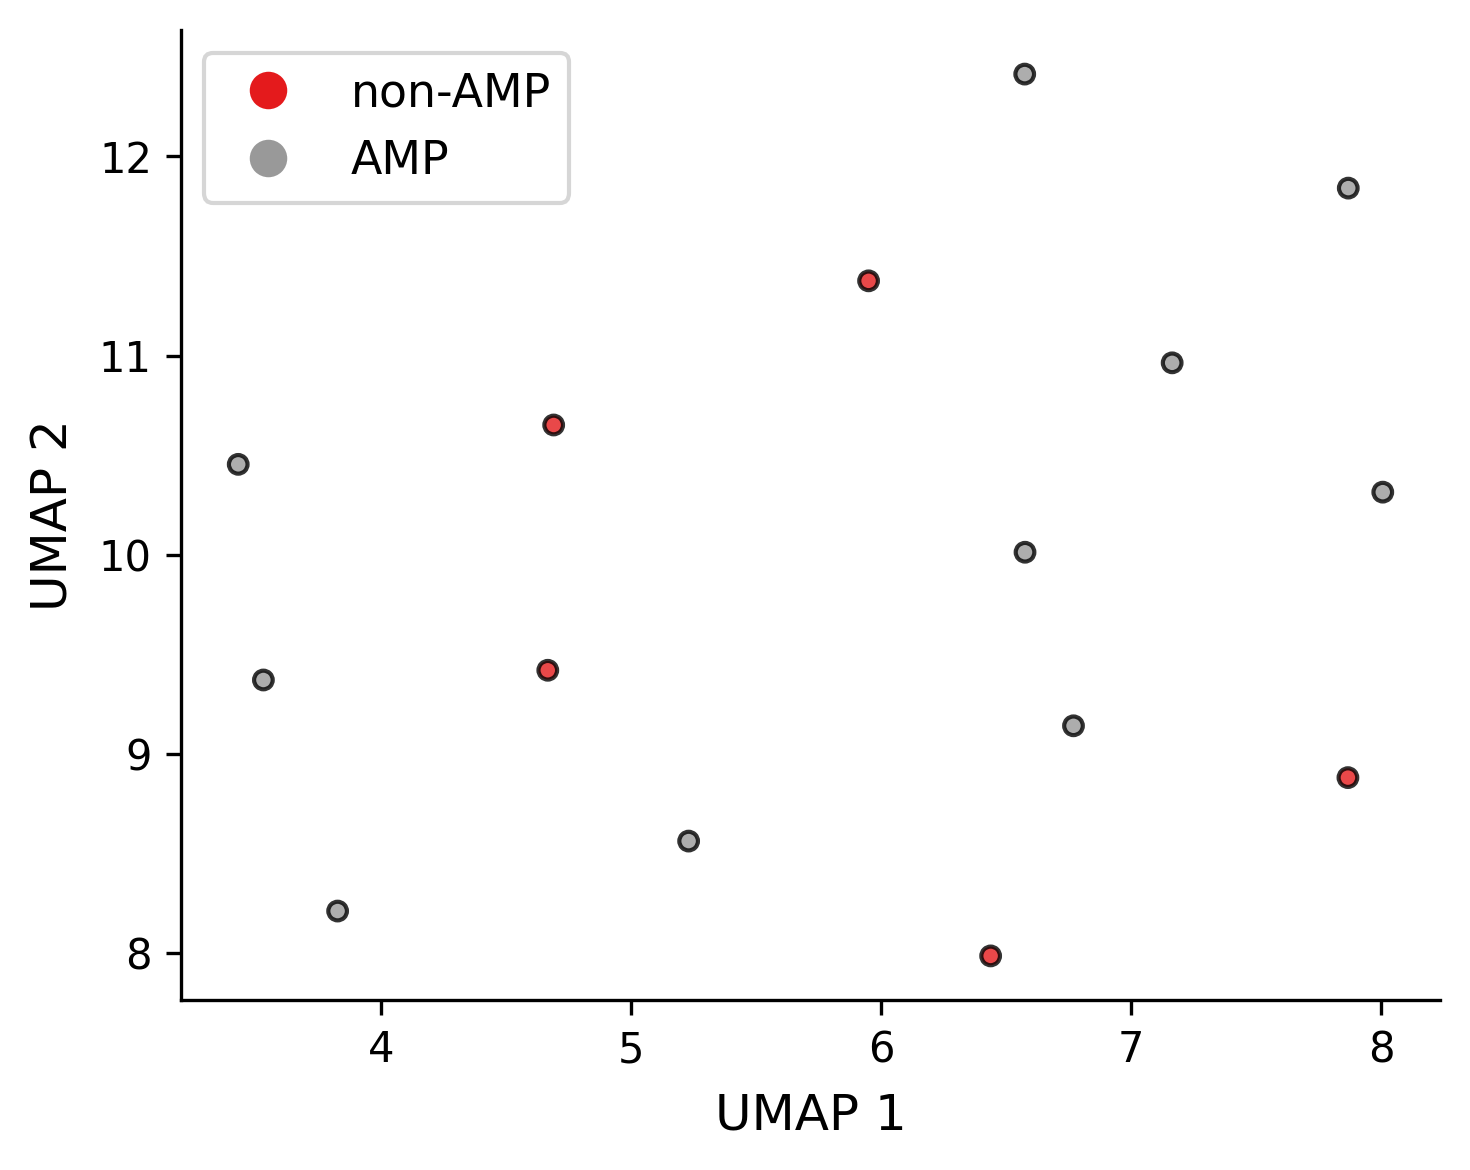

In [ ]:
# AMP labels
unique_labels = np.unique(y)
label_names = ['non-AMP', 'AMP']

# 2D UMAP plot
plt.figure(figsize=(5, 4), dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1],
                      c=y, cmap='Set1', s=20, edgecolor='k', alpha=0.8)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Set1(i / (len(unique_labels) - 1)), markersize=10, label=label_names[i])
           for i in unique_labels]
plt.legend(handles=handles, fontsize=11, loc='best')

# Set coordinate labels
plt.xlabel('UMAP 1', fontsize=12, labelpad=5)
plt.ylabel('UMAP 2', fontsize=12, labelpad=5)

# Clean up the plot
plt.grid(False)
sns.despine()
plt.tight_layout()

# Save the plot
#plt.savefig('Eco_UMAP.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Extract the ECFP features
ECFP = X_norm.drop(columns=['frac_CC'])
ECFP.head()

In [ ]:
# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.8, n_components=2,
                    metric='manhattan', random_state=random_state)

# Fit transform
X_umap = reducer.fit_transform(ECFP)

print(X_umap.shape)

In [ ]:
# 2D UMAP plot
plt.figure(figsize=(5, 4), dpi=300)
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1],
                      c=y, cmap='Set1', s=20, edgecolor='k', alpha=0.8)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Set1(i / (len(unique_labels) - 1)), markersize=10, label=label_names[i])
           for i in unique_labels]
plt.legend(handles=handles, fontsize=11, loc='best')

# Set coordinate labels
plt.xlabel('UMAP 1', fontsize=12, labelpad=5)
plt.ylabel('UMAP 2', fontsize=12, labelpad=5)

# Clean up the plot
plt.grid(False)
sns.despine()
plt.tight_layout()

plt.show()

In [ ]:
# Split dataset into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.15, stratify=y,
                                                   random_state=random_state)

print("Size of training set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))


In [ ]:
import os

# Convert X_test to dataframe
X_test_df = pd.DataFrame(X_test)

# Add target column
X_test_df['Result'] = y_test

# Create the directory if it doesn't exist
os.makedirs('dataset', exist_ok=True)

# Save to csv
X_test_df.to_csv('dataset/X_test.csv')
X_test_df

In [ ]:
# Performing Bayesian search to optimize parameters for logit
logit = LogisticRegression(max_iter=5000, random_state=random_state)

param = {'C': (1e-1,1e1, 'log-uniform')}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
logit_cv = BayesSearchCV(estimator=logit, search_spaces=param, cv=cv, scoring='roc_auc',
                         n_jobs=-1, random_state=random_state)

start_time = time.time()
logit_cv.fit(X_train, y_train)
end_time = time.time()
time_taken = timedelta(seconds=end_time - start_time)

print('best parameters: ', logit_cv.best_params_)
print('best score after search cv:', logit_cv.best_score_)
print('time taken: {}'.format(time_taken))

In [ ]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(4, 4))
plot_objective(logit_cv.optimizer_results_[0], ax=ax)
plt.show()
